In [1]:
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('./data/PS_20174392719_1491204439457_log.csv')

In [3]:
df['type'].unique().tolist()

['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN']

In [4]:
# Only 0,13% of the transactions are fraudulent
(df['isFraud'].value_counts()[1]/df['isFraud'].value_counts()[0])*100

0.129248881917699

In [5]:
# Data is highly imbalanced with only 0.129% of the transactions being fraudulent, so we need to balance the data
# We can see that the fraudulent transactions are only of type 'TRANSFER' and 'CASH_OUT'

df[df['isFraud']==1]['type'].unique().tolist()

['TRANSFER', 'CASH_OUT']

In [6]:
# remove lines with 'CASH_IN', 'DEBIT' and 'PAYMENT' as they are not fraudulent
#df = df[~df['type'].isin(['CASH_IN', 'DEBIT', 'PAYMENT'])]

# after removing the above lines, we can see that the fraudulent transactions dataset is still imbalanced
#df['isFraud'].value_counts()[1]/df['isFraud'].value_counts()[0]

<Axes: xlabel='isFraud', ylabel='count'>

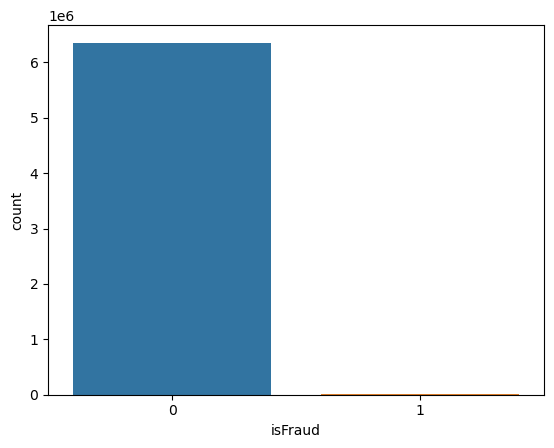

In [7]:
sns.countplot(x='isFraud', data=df)

In [8]:
# create a new dataframe with only the fraudulent and non-fraudulent transactions

df_fraud = df[df['isFraud'] == 1]
df_not_fraud = df[df['isFraud'] == 0]

In [9]:
print(len(df_not_fraud))
print(len(df_fraud))

6354407
8213


In [11]:
# use pandas sample to balance the dataset
df_not_fraud = df_not_fraud.sample(n=len(df_fraud)*50)

In [12]:
balanced_df = pd.concat([df_not_fraud, df_fraud])

In [14]:
df = balanced_df

<Axes: xlabel='isFraud', ylabel='count'>

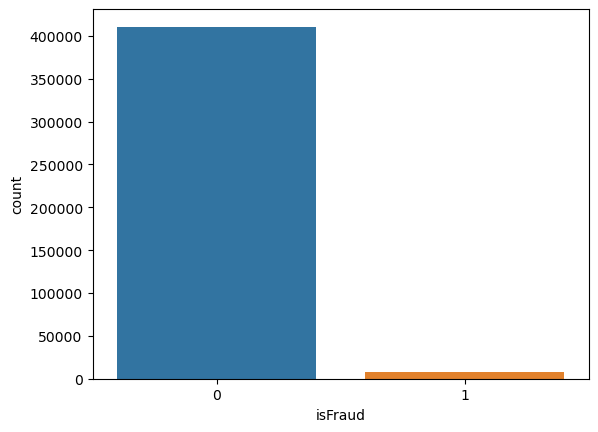

In [15]:
sns.countplot(x='isFraud', data=df)

In [16]:
# copy first letter of nameDest and to new column
df['nameOrig_first'] = df['nameOrig'].str[0]
df['nameDest_first'] = df['nameDest'].str[0]

In [17]:
# drop columns that are not needed
new_df = df.drop(['step','nameOrig','nameDest'], axis=1)

In [18]:
from sklearn.preprocessing import LabelEncoder
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

In [19]:
# split data into train, test and validation sets
X = new_df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = new_df['isFraud']

# encode categorical data
le = LabelEncoder()
columns_to_encode = ['type', 'nameDest_first', 'nameOrig_first']
X[columns_to_encode] = X[columns_to_encode].apply(lambda col: le.fit_transform(col))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(251317, 8) (251317,)
(83773, 8) (83773,)
(83773, 8) (83773,)


In [21]:
lazy_clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = lazy_clf.fit(X_train, X_val, y_train, y_val)

# output of LazyClassifier is in models.html

 97%|█████████▋| 28/29 [03:53<00:26, 26.98s/it]

[LightGBM] [Info] Number of positive: 4906, number of negative: 246411
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1284
[LightGBM] [Info] Number of data points in the train set: 251317, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019521 -> initscore=-3.916542
[LightGBM] [Info] Start training from score -3.916542


100%|██████████| 29/29 [03:54<00:00,  8.07s/it]


In [ ]:
print(models)
models.to_html('./models_balanced_data50.html')

In [20]:
#based on the output of LazyClassifier, we can see that the best performing model is XGBClassifier
from xgboost import XGBClassifier
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [18]:
# On test data
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score, log_loss, roc_auc_score, confusion_matrix

y_pred = xgb_clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('MSE: ', mean_squared_error(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))
print('Log Loss: ', log_loss(y_test, y_pred))
print('ROC AUC: ', roc_auc_score(y_test, y_pred))

Accuracy:  0.9988301720124623
MSE:  0.0011698279875377508
Precision:  0.9640330188679245
Recall:  0.9778708133971292
F1:  0.9709026128266034
Log Loss:  0.04216487450769937
ROC AUC:  0.988563913050497


In [19]:
# On validation data
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score, log_loss, roc_auc_score, confusion_matrix

y_predval = xgb_clf.predict(X_val)
print('Accuracy: ', accuracy_score(y_val, y_predval))
print('MSE: ', mean_squared_error(y_val, y_predval))
print('Precision: ', precision_score(y_val, y_predval))
print('Recall: ', recall_score(y_val, y_predval))
print('F1: ', f1_score(y_val, y_predval))
print('Log Loss: ', log_loss(y_val, y_predval))
print('ROC AUC: ', roc_auc_score(y_val, y_predval))

Accuracy:  0.9987824239313383
MSE:  0.0012175760686617407
Precision:  0.963141993957704
Recall:  0.9749235474006116
F1:  0.9689969604863223
Log Loss:  0.04388588979372791
ROC AUC:  0.9870904473957938


[[82077    61]
 [   41  1594]]


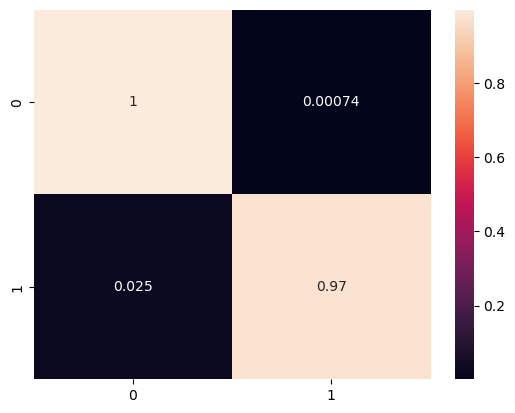

In [20]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_val, y_predval, normalize='true'), annot=True)
print(confusion_matrix(y_val, y_predval))

In [21]:
# let's try to improve the model by tuning the hyperparameters
# import optuna
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score, log_loss, roc_auc_score, confusion_matrix

# define objective function with hyperparameters for XGBoost

def objective(trial, X_train, y_train, X_test, y_test):
    X = X_train
    y = y_train

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 0.95, 0.05),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.6, 0.95, 0.05),
        'gamma': trial.suggest_int('gamma', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'tree_method': 'gpu_hist',
    }

    XGB_clf = XGBClassifier(**params)
    XGB_clf.fit(X, y)
    y_prediction = XGB_clf.predict(X_test)
    score = f1_score(y_test, y_prediction)
    return score

In [22]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=50, show_progress_bar=True)

[I 2023-10-11 17:31:45,254] A new study created in memory with name: no-name-5cc517ea-9adf-4c6b-9cb5-4a3b3ab18d41


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-10-11 17:31:48,347] Trial 0 finished with value: 0.9309712889431888 and parameters: {'n_estimators': 876, 'max_depth': 9, 'learning_rate': 0.010281742466711114, 'subsample': 0.95, 'colsample_bytree': 0.85, 'gamma': 9, 'min_child_weight': 2}. Best is trial 0 with value: 0.9309712889431888.
[I 2023-10-11 17:31:49,594] Trial 1 finished with value: 0.9485645933014354 and parameters: {'n_estimators': 816, 'max_depth': 9, 'learning_rate': 0.05597332182864298, 'subsample': 0.8, 'colsample_bytree': 0.95, 'gamma': 3, 'min_child_weight': 7}. Best is trial 1 with value: 0.9485645933014354.
[I 2023-10-11 17:31:51,047] Trial 2 finished with value: 0.9470198675496689 and parameters: {'n_estimators': 767, 'max_depth': 10, 'learning_rate': 0.03490759154993503, 'subsample': 0.7, 'colsample_bytree': 0.75, 'gamma': 4, 'min_child_weight': 6}. Best is trial 1 with value: 0.9485645933014354.
[I 2023-10-11 17:31:52,325] Trial 3 finished with value: 0.8957928802588997 and parameters: {'n_estimators': 

In [23]:
optuna.visualization.plot_optimization_history(study)

In [24]:
optuna.visualization.plot_slice(study)

In [25]:
model_best_params = XGBClassifier(**study.best_params)
model_best_params.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.041862692807856414,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=656, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [26]:
print('Results with best params on test data:')
y_pred2 = model_best_params.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred2))
print('MSE: ', mean_squared_error(y_test, y_pred2))
print('Precision: ', precision_score(y_test, y_pred2))
print('Recall: ', recall_score(y_test, y_pred2))
print('F1: ', f1_score(y_test, y_pred2))
print('Log Loss: ', log_loss(y_test, y_pred2))
print('ROC AUC: ', roc_auc_score(y_test, y_pred2))

Results with best params on test data:
Accuracy:  0.9986391796879663
MSE:  0.00136082031203371
Precision:  0.9593160377358491
Recall:  0.9730861244019139
F1:  0.9661520190023754
Log Loss:  0.049048935651813515
ROC AUC:  0.9861228480744543


In [27]:
y_pred = model_best_params.predict(X_val)

In [28]:
print('Results with best params on validation data:')
print('Accuracy: ', accuracy_score(y_val, y_pred))
print('MSE: ', mean_squared_error(y_val, y_pred))
print('Precision: ', precision_score(y_val, y_pred))
print('Recall: ', recall_score(y_val, y_pred))
print('F1: ', f1_score(y_val, y_pred))
print('Log Loss: ', log_loss(y_val, y_pred))
print('ROC AUC: ', roc_auc_score(y_val, y_pred))

Results with best params on validation data:
Accuracy:  0.9986033686271233
MSE:  0.0013966313728767026
Precision:  0.9583333333333334
Recall:  0.9706422018348624
F1:  0.9644484958979033
Log Loss:  0.050339697116334924
ROC AUC:  0.98490107608118


[[82069    69]
 [   48  1587]]


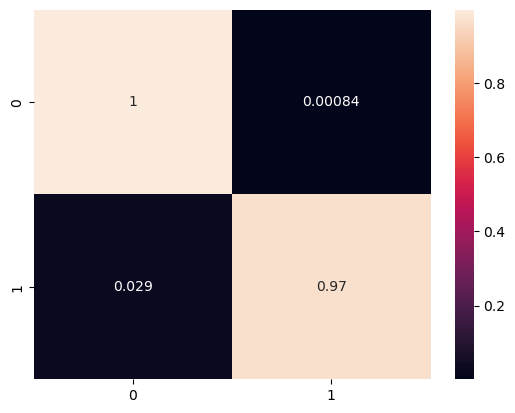

In [29]:
# Confusion Matrix on validation data
sns.heatmap(confusion_matrix(y_val, y_pred, normalize='true'), annot=True)
print(confusion_matrix(y_val, y_pred))

## not sure about this

In [30]:
# test predictions on full dataset

df_full = pd.read_csv('./data/PS_20174392719_1491204439457_log.csv')

#df_full = df_full.sample(n=100000)

# copy first letter of nameDest and to new column
df_full['nameOrig_first'] = df_full['nameOrig'].str[0]
df_full['nameDest_first'] = df_full['nameDest'].str[0]

# split data into train, test and validation sets
X_full = df_full.drop(['step','nameOrig','nameDest','isFraud', 'isFlaggedFraud'], axis=1)
y_full = df_full['isFraud']

# encode categorical data
le = LabelEncoder()
columns_to_encode = ['type', 'nameDest_first', 'nameOrig_first']
X_full[columns_to_encode] = X_full[columns_to_encode].apply(lambda col: le.fit_transform(col))

In [31]:
print('Results with best params on full data:')
y_pred_full = model_best_params.predict(X_full)
print('Accuracy: ', accuracy_score(y_full, y_pred_full))
print('MSE: ', mean_squared_error(y_full, y_pred_full))
print('Precision: ', precision_score(y_full, y_pred_full))
print('Recall: ', recall_score(y_full, y_pred_full))
print('F1: ', f1_score(y_full, y_pred_full))
print('Log Loss: ', log_loss(y_full, y_pred_full))
print('ROC AUC: ', roc_auc_score(y_full, y_pred_full))

Results with best params on full data:
Accuracy:  0.9991714105195658
MSE:  0.0008285894804341608
Precision:  0.6110397946084724
Recall:  0.9852672592231828
F1:  0.7542878448918718
Log Loss:  0.029865392034637995
ROC AUC:  0.9922283203514196


[[6349256    5151]
 [    121    8092]]


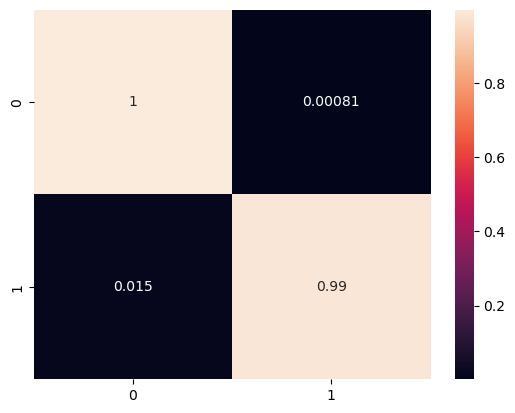

In [32]:
# Confusion Matrix on validation data
sns.heatmap(confusion_matrix(y_full, y_pred_full, normalize='true'), annot=True)
print(confusion_matrix(y_full, y_pred_full))

In [ ]:
"1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0"

In [38]:
# create fictional transaction to test the model: type, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest, nameOrig_first, nameDest_first
to_test = {
    'type': 5,
    'amount': 254,
    'oldbalanceOrg': 254,
    'newbalanceOrig': 0,
    'oldbalanceDest': 0,
    'newbalanceDest': 0,
    'nameOrig_first': 0,
    'nameDest_first': 0
}
to_test = pd.DataFrame([to_test])

skuska = model_best_params.predict(to_test)

# Interpret the prediction
if skuska[0] == 1:
    print("The model predicts that the transaction is fraudulent.")
else:
    print("The model predicts that the transaction is not fraudulent.")

The model predicts that the transaction is fraudulent.
